In [195]:
# ------------------ Clustering & ML ------------------
from sklearn.cluster import SpectralBiclustering
from scipy import stats
from scipy.stats import linregress

# ------------------ Core Libraries -------------------
import numpy as np
import pandas as pd
import math
import os
import warnings
import ast
from glob import glob
import itertools

# ------------------ AnnData & Spatial Analysis -------
import scanpy as sc
import squidpy as sq
from anndata import AnnData
import geopandas as gpd

# ------------------ Geometry & Spatial --------------
from shapely.ops import unary_union
from shapely.geometry import Polygon as sPolygon
from matplotlib.patches import Polygon, Patch
from matplotlib.lines import Line2D


# ------------------ Plotting -------------------------
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib.colors import BoundaryNorm, LinearSegmentedColormap, ListedColormap, to_hex
import matplotlib.image as mpimg
import matplotlib as mpl

# ------------------ Image Handling -------------------
from PIL import Image
import cv2

# ------------------ Settings -------------------------
warnings.filterwarnings('ignore')
Image.MAX_IMAGE_PIXELS = None
%matplotlib inline

# Cell Cell Communication

This analysis uses L-R communication analysis to explore the relationship between communications and spatial locations. Below is a structured overview of the pipeline.
- Focus on **one specific** fov using local coordinates/**multiple fovs** using global coordinates
- Focus on **multiple fovs** using local coordinates (updated later)

---

### Summary of Analysis Steps

| Step | Description |
|------|-------------|
| **1. Grouping cells based on spatial locations** | Group them based on distance between two cell subpopulations |
| **2. L-R pairs database** | Use CellChat V1 database and there are Cell Cell Contact, Secreted Signaling and ECM-Receptor categories in it |
| **3. Calculation of p-values and intensity scores of L-R pairs** | Gene expression product followed by permutation analysis |
| **4. Identification of L-R pairs changing with distances based on spatial locations** | Utilize linear regression to identify L-R pairs |
| **5. Spatial Visualization** | Plot spatial scatter, dotplot and more |

---



In [66]:
# load data
data_read = '../raw/' # for raw data 
data_save = '../data/' # for processed data or intermediate result
analysis_save = '../analysis/' # for plots
database_read = '../database/' # for online database

adata = sc.read(data_save+'filtered_adata.h5ad')
cell_meta = pd.read_csv(data_save+'filtered_metadata_file.csv', index_col=0)
polygon_file = pd.read_csv(data_save+'filtered_polygons.csv', index_col=0)
coordinates = pd.read_csv(data_save+'filtered_coordinates.csv', index_col=0)
fov_id = [i for i in range(1,23) if i not in [3, 20]]

image = cv2.imread(data_read+"CellComposite/"+"CellComposite_F001.jpg", cv2.IMREAD_COLOR)
xlim_image = image.shape[1]
ylim_image = image.shape[0]

L_R_DB = pd.read_csv(database_read+'Human_CellChat_LR.csv', index_col=0)
L_R_DB_list= L_R_DB['interaction_name_2'].str.split(' - ').tolist()
def sort_ligand_receptor(lr):
    if '+' in lr:
        return lr.strip('()').split('+')
    else:
        return [lr]

L_R_DB_list = [(sort_ligand_receptor(lr[0]), sort_ligand_receptor(lr[1])) for lr in L_R_DB_list]

In [21]:
# focus on one fov
## prepare count, adata, polygon based on fov chosen
fov_chosen = 16
adata_sub = adata[adata.obs['fov'] == fov_chosen]
counts_sub = pd.DataFrame(adata_sub.X.toarray(), columns=adata_sub.var_names, index=adata_sub.obs_names)
counts_sub['cell'] = counts_sub.index.tolist()

polygon_sub_file = polygon_file[polygon_file['fov'] == fov_chosen]
polygon_set = []
cell_id = []
for cell, group in polygon_sub_file.groupby('cell'):
    polygon_tmp = sPolygon([ (i[0],i[1]) for i in group[['x_local_px', 'y_local_px']].values])
    polygon_set.append(polygon_tmp)
    cell_id.append(cell)
gdf = gpd.GeoDataFrame(geometry=polygon_set)
gdf['cell'] = cell_id
gdf = gdf.merge(adata_sub.obs[['cell','big_cell_type']],on='cell')
gdf

,geometry,cell,big_cell_type
0,"POLYGON ((3400 3644, 3405 3643, 3413 3641, 341...",16_10,IM
1,"POLYGON ((1272 3202, 1277 3201, 1280 3200, 129...",16_1000,IM
2,"POLYGON ((1528 3202, 1533 3196, 1538 3189, 153...",16_1001,IM
3,"POLYGON ((3876 3189, 3880 3185, 3880 3184, 384...",16_1002,IM
4,"POLYGON ((888 3196, 889 3195, 893 3187, 895 31...",16_1004,FB
...,...,...,...
1695,"POLYGON ((910 3209, 964 3190, 966 3186, 967 31...",16_994,IM
1696,"POLYGON ((2890 3212, 2895 3211, 2898 3210, 291...",16_996,IM
1697,"POLYGON ((4427 3202, 4453 3194, 4465 3190, 448...",16_997,IM
1698,"POLYGON ((1472 3208, 1477 3207, 1480 3206, 148...",16_998,FB


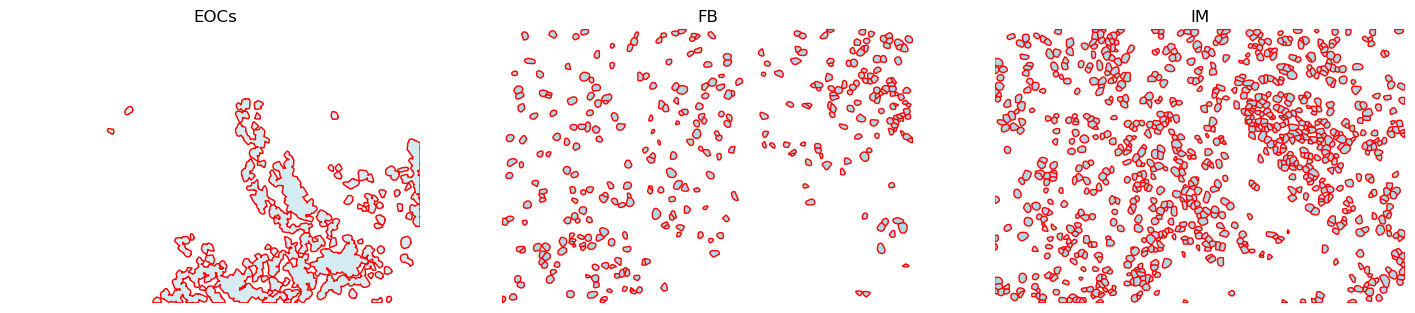

In [29]:
## group cells (optional if we do not want to use leiden clustering) based on spatial locations
fig, axs = plt.subplots(1,3,figsize=(18,6))
axs = axs.flatten()



### EOCs
ax = axs[0]
merged_polygon = unary_union(gdf[gdf['big_cell_type'] == 'EOC']['geometry'].tolist())
if merged_polygon.geom_type == 'Polygon':
    ax.fill(*merged.exterior.xy, color='lightblue', alpha=0.5)
    ax.plot(*boundary.xy, color='red', linewidth=1)
elif merged_polygon.geom_type == 'MultiPolygon':
    for poly in merged_polygon.geoms:
        ax.fill(*poly.exterior.xy, color='lightblue', alpha=0.5)
        ax.plot(*poly.exterior.xy, color='red', linewidth=1)

ax.set_aspect('equal')
ax.set_xlim(0, xlim_image)
ax.set_ylim(0, ylim_image)
ax.axis('off')
ax.set_title("EOCs")

### FB
ax = axs[1]
gdf_FB = gdf[gdf['big_cell_type'] == 'FB']
gdf_FB.plot(ax=ax, color='lightblue', edgecolor='red', linewidth=1)
ax.set_aspect('equal')
ax.set_xlim(0, xlim_image)
ax.set_ylim(0, ylim_image)
ax.axis('off')
ax.set_title("FB")

### IM
ax = axs[2]
gdf_IM = gdf[gdf['big_cell_type'] == 'IM']
gdf_IM.plot(ax=ax, color='lightblue', edgecolor='red', linewidth=1)
ax.set_aspect('equal')
ax.set_xlim(0, xlim_image)
ax.set_ylim(0, ylim_image)
ax.axis('off')
ax.set_title("IM")


plt.show()


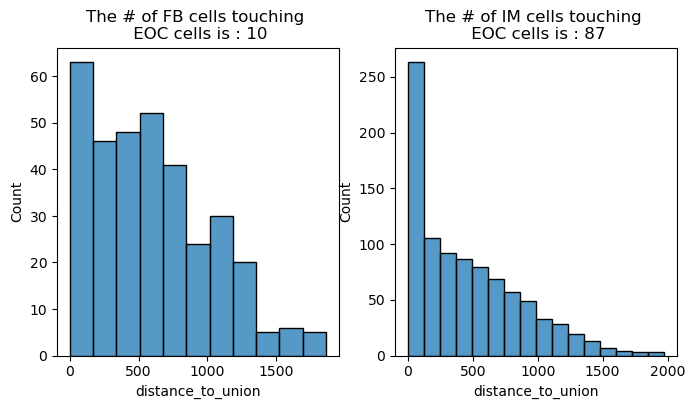

In [50]:
## play with distance between EOCs and FBs/IMs
gdf_FB['distance_to_union'] = gdf_FB.geometry.apply(lambda g: g.distance(merged_polygon))
gdf_IM['distance_to_union'] = gdf_IM.geometry.apply(lambda g: g.distance(merged_polygon))

fig, axs = plt.subplots(1,2,figsize=(8,4))

ax = axs[0]
sns.histplot(gdf_FB, x='distance_to_union', ax=ax)
ax.set_title('The # of FB cells touching \n EOC cells is : '+str(int((gdf_FB['distance_to_union'] == 0).sum())))

ax = axs[1]
sns.histplot(gdf_IM, x='distance_to_union', ax=ax)
ax.set_title('The # of IM cells touching \n EOC cells is : '+str(int((gdf_IM['distance_to_union'] == 0).sum())))

plt.show()

gdf_FB['spatial_group'] = gdf_FB.distance_to_union.apply(lambda g: 'FB'+'_'+'touch' if g == 0 else 'FB'+'_'+'distant').tolist()
gdf_IM['spatial_group'] = gdf_IM.distance_to_union.apply(lambda g: 'IM'+'_'+'touch' if g == 0 else 'IM'+'_'+'distant').tolist()
gdf_EOC = gdf[gdf['big_cell_type'] == 'EOC']
gdf_EOC['distance_to_union'] = 0
gdf_EOC['spatial_group'] = 'EOC'

gdf_CC = pd.concat([gdf_FB, gdf_IM, gdf_EOC], axis=0)
gdf_CC = gdf_CC.merge(counts_sub, on='cell')
gdf_CC_count = gdf_CC.iloc[:, ~gdf_CC.columns.isin(['geometry', 'cell', 'big_cell_type', 'distance_to_union', 'spatial_group'])]
gdf_CC_count.index = gdf_CC.cell.tolist()

In [83]:
# calculate the CCI scores and p values
## gene expression product followed by permutation test
def compute_mean_expression(expr_matrix, cell_types):
    """
    Compute mean expression of each gene within each cell type.
    """
    expr_matrix = expr_matrix.copy()
    expr_matrix['cell_type'] = cell_types
    mean_expr = expr_matrix.groupby('cell_type').mean()
    return mean_expr

def compute_interaction_scores(mean_expr, lr_complexes):
    """
    Compute interaction scores for each ligand-receptor complex across cell type pairs.
    """
    scores = []
    cell_types = mean_expr.index
    for ligand_subunits, receptor_subunits in lr_complexes:
        # Skip if any subunit is missing
        if not all(subunit in mean_expr.columns for subunit in ligand_subunits + receptor_subunits):
            continue
        for source in cell_types:
            for target in cell_types:
                ligand_expr = min(mean_expr.loc[source, subunit] for subunit in ligand_subunits)
                receptor_expr = min(mean_expr.loc[target, subunit] for subunit in receptor_subunits)
                score = ligand_expr * receptor_expr
                scores.append({
                    'ligand': '_'.join(ligand_subunits),
                    'receptor': '_'.join(receptor_subunits),
                    'source': source,
                    'target': target,
                    'score': score
                })
    return pd.DataFrame(scores)

def permutation_test(expr_matrix, cell_types, lr_complexes, n_permutations=1000, random_state=None):
    """
    Perform permutation testing to compute p-values for interaction scores.
    """
    if isinstance(cell_types, list):
        cell_types = pd.Series(cell_types, index=expr_matrix.index)
    rng = np.random.default_rng(random_state)
    observed_mean_expr = compute_mean_expression(expr_matrix, cell_types)
    observed_scores = compute_interaction_scores(observed_mean_expr, lr_complexes)
    observed_scores['p_value'] = 0.0

    # Initialize a dictionary to store null distributions
    null_distributions = {}
    for idx, row in observed_scores.iterrows():
        key = (row['ligand'], row['receptor'], row['source'], row['target'])
        null_distributions[key] = []

    # Perform permutations
    for i in range(n_permutations):
        permuted_cell_types = cell_types.sample(frac=1, replace=False, random_state=rng.integers(1e6)).reset_index(drop=True)
        permuted_mean_expr = compute_mean_expression(expr_matrix, permuted_cell_types.tolist())
        permuted_scores = compute_interaction_scores(permuted_mean_expr, lr_complexes)

        for idx, row in permuted_scores.iterrows():
            key = (row['ligand'], row['receptor'], row['source'], row['target'])
            null_distributions[key].append(row['score'])

    # Compute p-values
    for idx, row in observed_scores.iterrows():
        key = (row['ligand'], row['receptor'], row['source'], row['target'])
        null_scores = null_distributions.get(key, [])
        if null_scores:
            p_val = np.mean([score >= row['score'] for score in null_scores])
            observed_scores.at[idx, 'p_value'] = p_val
        else:
            observed_scores.at[idx, 'p_value'] = np.nan  # Handle missing null distribution

    return observed_scores

mean_expr = compute_mean_expression(gdf_CC_count, gdf_CC.spatial_group.tolist())
scores = compute_interaction_scores(mean_expr, L_R_DB_list)
pval = permutation_test(gdf_CC_count, gdf_CC.spatial_group.tolist(), L_R_DB_list, n_permutations=100, random_state=521)
pval['interaction_name_2'] = [i+'_'+j for i,j in zip(pval['ligand'], pval['receptor'])]


In [143]:
## focus on cell-cell contact
df_CC = pval[['source','target','score','p_value','interaction_name_2']].merge(L_R_DB, left_on='interaction_name_2', right_index=True)
print(df_CC.annotation.value_counts())
df_CC_CCC = df_CC[df_CC['annotation'] == 'Cell-Cell Contact']
df_CC_CCC['L-R'] = [i+'-->'+j for i,j in zip(df_CC_CCC['ligand'],df_CC_CCC['receptor'])]
df_CC_CCC['S-D'] = [i+'-->'+j for i,j in zip(df_CC_CCC['source'],df_CC_CCC['target'])]
tmp = df_CC_CCC[df_CC_CCC['S-D'].isin(['EOC-->FB_touch','EOC-->IM_touch','FB_touch-->EOC','IM_touch-->EOC'])]
tmp['Value_scaled_by_row'] = tmp[['interaction_name','score']].groupby('interaction_name')['score'].transform(
    lambda x: (x - x.min()) / (x.max() - x.min())
)
tmp['Value_scaled_by_column'] = tmp[['S-D','score']].groupby('S-D')['score'].transform(
    lambda x: (x - x.min()) / (x.max() - x.min())
)
tmp['p_significance'] = -np.log10(tmp['p_value']+ 1e-10) # transform p value to -log10(p value+1e-10)

annotation
Secreted Signaling    4500
ECM-Receptor          2025
Cell-Cell Contact     2025
Name: count, dtype: int64


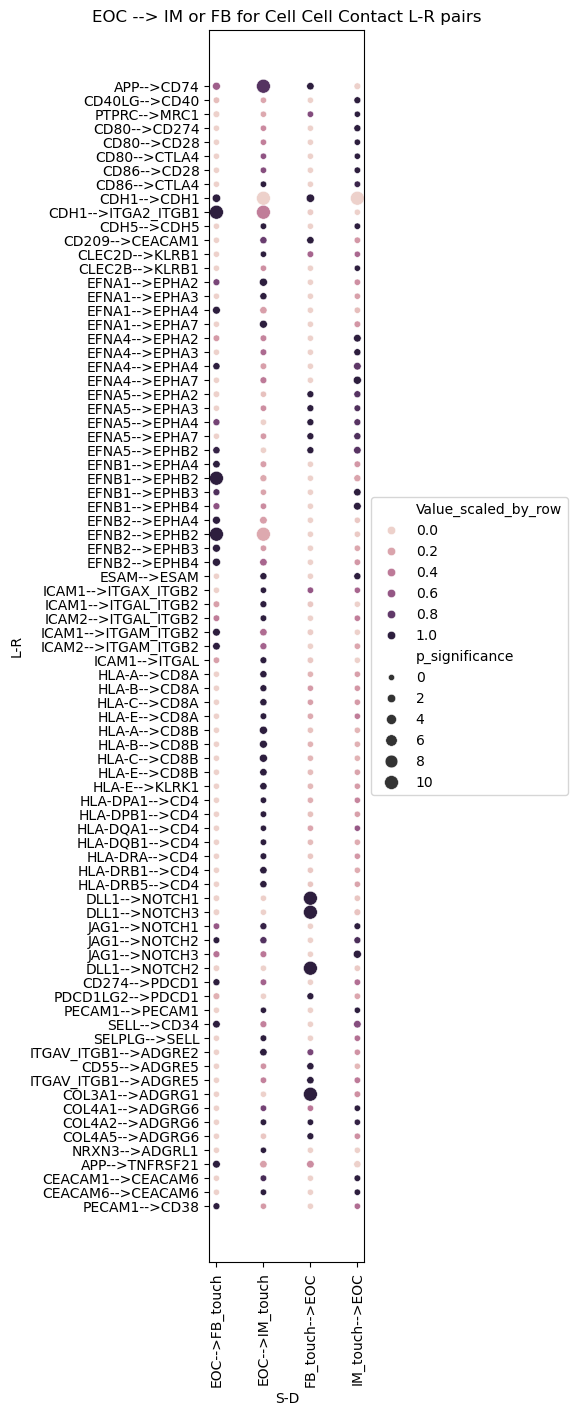

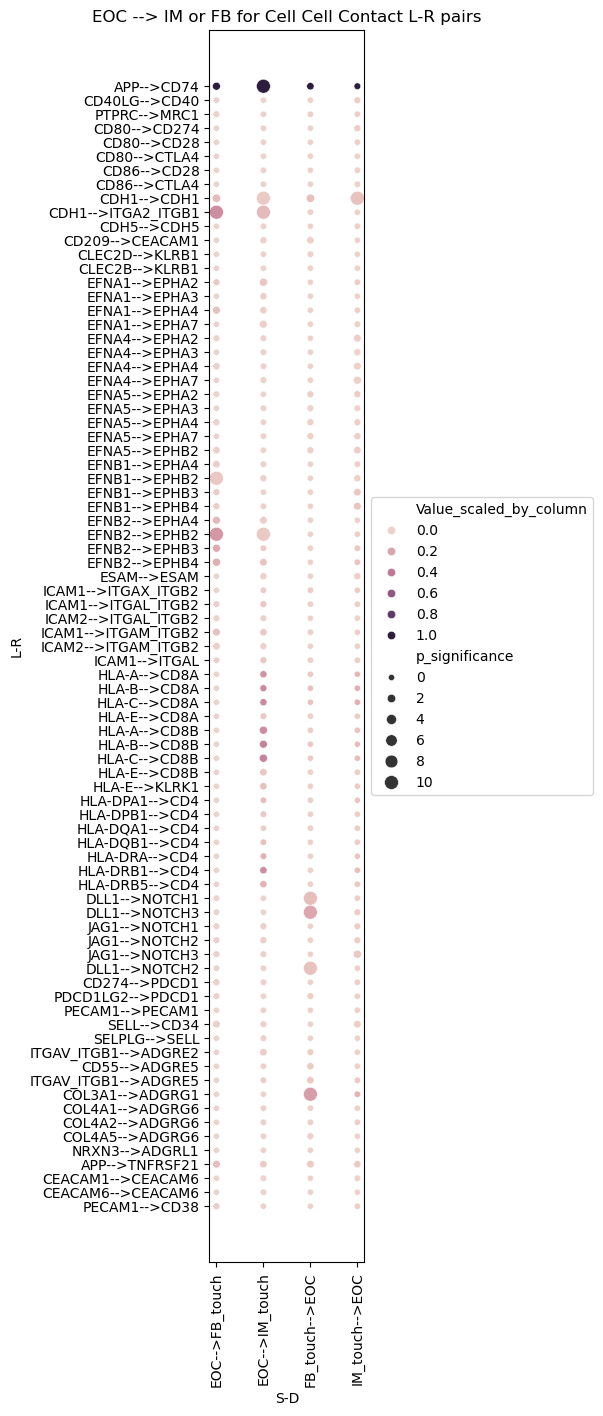

In [157]:
plt.figure(figsize=(2,16))
sns.scatterplot(data=tmp,
                x='S-D',
                y='L-R',
                hue='Value_scaled_by_row',
                size='p_significance',
                sizes=(20,100))
plt.xticks(rotation='vertical')
plt.title('EOC --> IM or FB for Cell Cell Contact L-R pairs')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), title='')
plt.show()

plt.figure(figsize=(2,16))
sns.scatterplot(data=tmp,
                x='S-D',
                y='L-R',
                hue='Value_scaled_by_column',
                size='p_significance',
                sizes=(20,100))
plt.xticks(rotation='vertical')
plt.title('EOC --> IM or FB for Cell Cell Contact L-R pairs')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), title='')
plt.show()

tmp.to_csv(data_save+'CCC_CCI_EOC_FB_IM.csv')

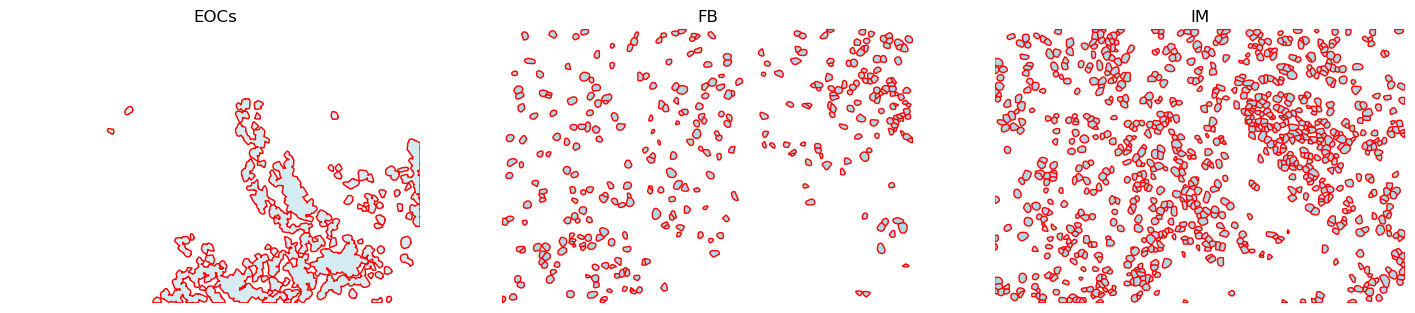

In [154]:
## group cells (optional if we do not want to use leiden clustering) based on spatial locations
fig, axs = plt.subplots(1,3,figsize=(18,6))
axs = axs.flatten()



### EOCs
ax = axs[0]
merged_polygon = unary_union(gdf[gdf['big_cell_type'] == 'EOC']['geometry'].tolist())
if merged_polygon.geom_type == 'Polygon':
    ax.fill(*merged.exterior.xy, color='lightblue', alpha=0.5)
    ax.plot(*boundary.xy, color='red', linewidth=1)
elif merged_polygon.geom_type == 'MultiPolygon':
    for poly in merged_polygon.geoms:
        ax.fill(*poly.exterior.xy, color='lightblue', alpha=0.5)
        ax.plot(*poly.exterior.xy, color='red', linewidth=1)

ax.set_aspect('equal')
ax.set_xlim(0, xlim_image)
ax.set_ylim(0, ylim_image)
ax.axis('off')
ax.set_title("EOCs")

### FB
ax = axs[1]
gdf_FB = gdf[gdf['big_cell_type'] == 'FB']
gdf_FB.plot(ax=ax, color='lightblue', edgecolor='red', linewidth=1)
ax.set_aspect('equal')
ax.set_xlim(0, xlim_image)
ax.set_ylim(0, ylim_image)
ax.axis('off')
ax.set_title("FB")

### IM
ax = axs[2]
gdf_IM = gdf[gdf['big_cell_type'] == 'IM']
gdf_IM.plot(ax=ax, color='lightblue', edgecolor='red', linewidth=1)
ax.set_aspect('equal')
ax.set_xlim(0, xlim_image)
ax.set_ylim(0, ylim_image)
ax.axis('off')
ax.set_title("IM")


plt.show()



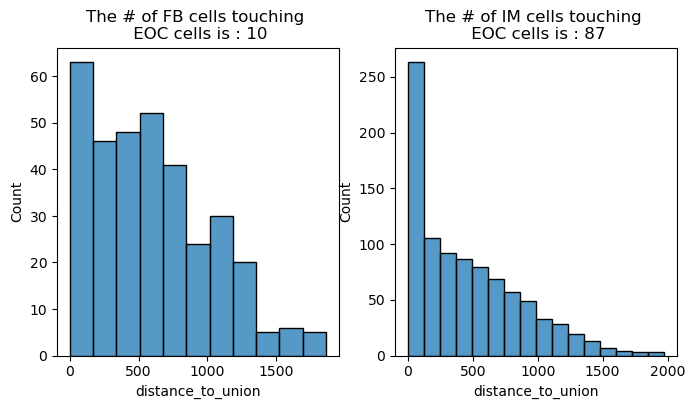

In [155]:
## play with distance between EOCs and FBs/IMs
gdf_FB['distance_to_union'] = gdf_FB.geometry.apply(lambda g: g.distance(merged_polygon))
gdf_IM['distance_to_union'] = gdf_IM.geometry.apply(lambda g: g.distance(merged_polygon))

fig, axs = plt.subplots(1,2,figsize=(8,4))

ax = axs[0]
sns.histplot(gdf_FB, x='distance_to_union', ax=ax)
ax.set_title('The # of FB cells touching \n EOC cells is : '+str(int((gdf_FB['distance_to_union'] == 0).sum())))

ax = axs[1]
sns.histplot(gdf_IM, x='distance_to_union', ax=ax)
ax.set_title('The # of IM cells touching \n EOC cells is : '+str(int((gdf_IM['distance_to_union'] == 0).sum())))

plt.show()

gdf_FB['spatial_group'] = pd.qcut(gdf_FB['distance_to_union'], q=3, labels=['FB_N', 'FB_M', 'FB_D']) # evenly divide them into 3 groups based on distance
gdf_IM['spatial_group'] = pd.qcut(gdf_IM['distance_to_union'], q=3, labels=['IM_N', 'IM_M', 'IM_D']) # evenly divide them into 3 groups based on distance

gdf_EOC = gdf[gdf['big_cell_type'] == 'EOC']
gdf_EOC['distance_to_union'] = 0
gdf_EOC['spatial_group'] = 'EOC'

gdf_CC = pd.concat([gdf_FB, gdf_IM, gdf_EOC], axis=0)
gdf_CC = gdf_CC.merge(counts_sub, on='cell')
gdf_CC_count = gdf_CC.iloc[:, ~gdf_CC.columns.isin(['geometry', 'cell', 'big_cell_type', 'distance_to_union', 'spatial_group'])]
gdf_CC_count.index = gdf_CC.cell.tolist()

In [159]:
# calculate the CCI scores and p values
## gene expression product followed by permutation test
def compute_mean_expression(expr_matrix, cell_types):
    """
    Compute mean expression of each gene within each cell type.
    """
    expr_matrix = expr_matrix.copy()
    expr_matrix['cell_type'] = cell_types
    mean_expr = expr_matrix.groupby('cell_type').mean()
    return mean_expr

def compute_interaction_scores(mean_expr, lr_complexes):
    """
    Compute interaction scores for each ligand-receptor complex across cell type pairs.
    """
    scores = []
    cell_types = mean_expr.index
    for ligand_subunits, receptor_subunits in lr_complexes:
        # Skip if any subunit is missing
        if not all(subunit in mean_expr.columns for subunit in ligand_subunits + receptor_subunits):
            continue
        for source in cell_types:
            for target in cell_types:
                ligand_expr = min(mean_expr.loc[source, subunit] for subunit in ligand_subunits)
                receptor_expr = min(mean_expr.loc[target, subunit] for subunit in receptor_subunits)
                score = ligand_expr * receptor_expr
                scores.append({
                    'ligand': '_'.join(ligand_subunits),
                    'receptor': '_'.join(receptor_subunits),
                    'source': source,
                    'target': target,
                    'score': score
                })
    return pd.DataFrame(scores)

def permutation_test(expr_matrix, cell_types, lr_complexes, n_permutations=1000, random_state=None):
    """
    Perform permutation testing to compute p-values for interaction scores.
    """
    if isinstance(cell_types, list):
        cell_types = pd.Series(cell_types, index=expr_matrix.index)
    rng = np.random.default_rng(random_state)
    observed_mean_expr = compute_mean_expression(expr_matrix, cell_types)
    observed_scores = compute_interaction_scores(observed_mean_expr, lr_complexes)
    observed_scores['p_value'] = 0.0

    # Initialize a dictionary to store null distributions
    null_distributions = {}
    for idx, row in observed_scores.iterrows():
        key = (row['ligand'], row['receptor'], row['source'], row['target'])
        null_distributions[key] = []

    # Perform permutations
    for i in range(n_permutations):
        permuted_cell_types = cell_types.sample(frac=1, replace=False, random_state=rng.integers(1e6)).reset_index(drop=True)
        permuted_mean_expr = compute_mean_expression(expr_matrix, permuted_cell_types.tolist())
        permuted_scores = compute_interaction_scores(permuted_mean_expr, lr_complexes)

        for idx, row in permuted_scores.iterrows():
            key = (row['ligand'], row['receptor'], row['source'], row['target'])
            null_distributions[key].append(row['score'])

    # Compute p-values
    for idx, row in observed_scores.iterrows():
        key = (row['ligand'], row['receptor'], row['source'], row['target'])
        null_scores = null_distributions.get(key, [])
        if null_scores:
            p_val = np.mean([score >= row['score'] for score in null_scores])
            observed_scores.at[idx, 'p_value'] = p_val
        else:
            observed_scores.at[idx, 'p_value'] = np.nan  # Handle missing null distribution

    return observed_scores

mean_expr = compute_mean_expression(gdf_CC_count, gdf_CC.spatial_group.tolist())
scores = compute_interaction_scores(mean_expr, L_R_DB_list)
pval = permutation_test(gdf_CC_count, gdf_CC.spatial_group.tolist(), L_R_DB_list, n_permutations=100, random_state=521)
pval['interaction_name_2'] = [i+'_'+j for i,j in zip(pval['ligand'], pval['receptor'])]

In [170]:
## focus on Secreting Signaling (the same workflow applied to ECM-Receptor)
df_CC = pval[['source','target','score','p_value','interaction_name_2']].merge(L_R_DB, left_on='interaction_name_2', right_index=True)
print(df_CC.annotation.value_counts())
df_CC_SS = df_CC[df_CC['annotation'] == 'Secreted Signaling']
df_CC_SS['L-R'] = [i+'-->'+j for i,j in zip(df_CC_SS['ligand'],df_CC_SS['receptor'])]
df_CC_SS['S-D'] = [i+'-->'+j for i,j in zip(df_CC_SS['source'],df_CC_SS['target'])]

list1 = ['EOC']
list2 = ['FB_N','FB_M','FB_D','IM_N','IM_D','IM_M']

tmp = df_CC_SS[df_CC_SS['S-D'].isin([x+'-->'+y for x in list1 for y in list2]+[y+'-->'+x for x in list1 for y in list2])]
tmp['Value_scaled_by_row'] = tmp[['interaction_name','score']].groupby('interaction_name')['score'].transform(
    lambda x: (x - x.min()) / (x.max() - x.min())
)
tmp['Value_scaled_by_column'] = tmp[['S-D','score']].groupby('S-D')['score'].transform(
    lambda x: (x - x.min()) / (x.max() - x.min())
)
tmp['p_significance'] = -np.log10(tmp['p_value']+ 1e-10) # transform p value to -log10(p value+1e-10)

annotation
Secreted Signaling    8820
ECM-Receptor          3969
Cell-Cell Contact     3969
Name: count, dtype: int64


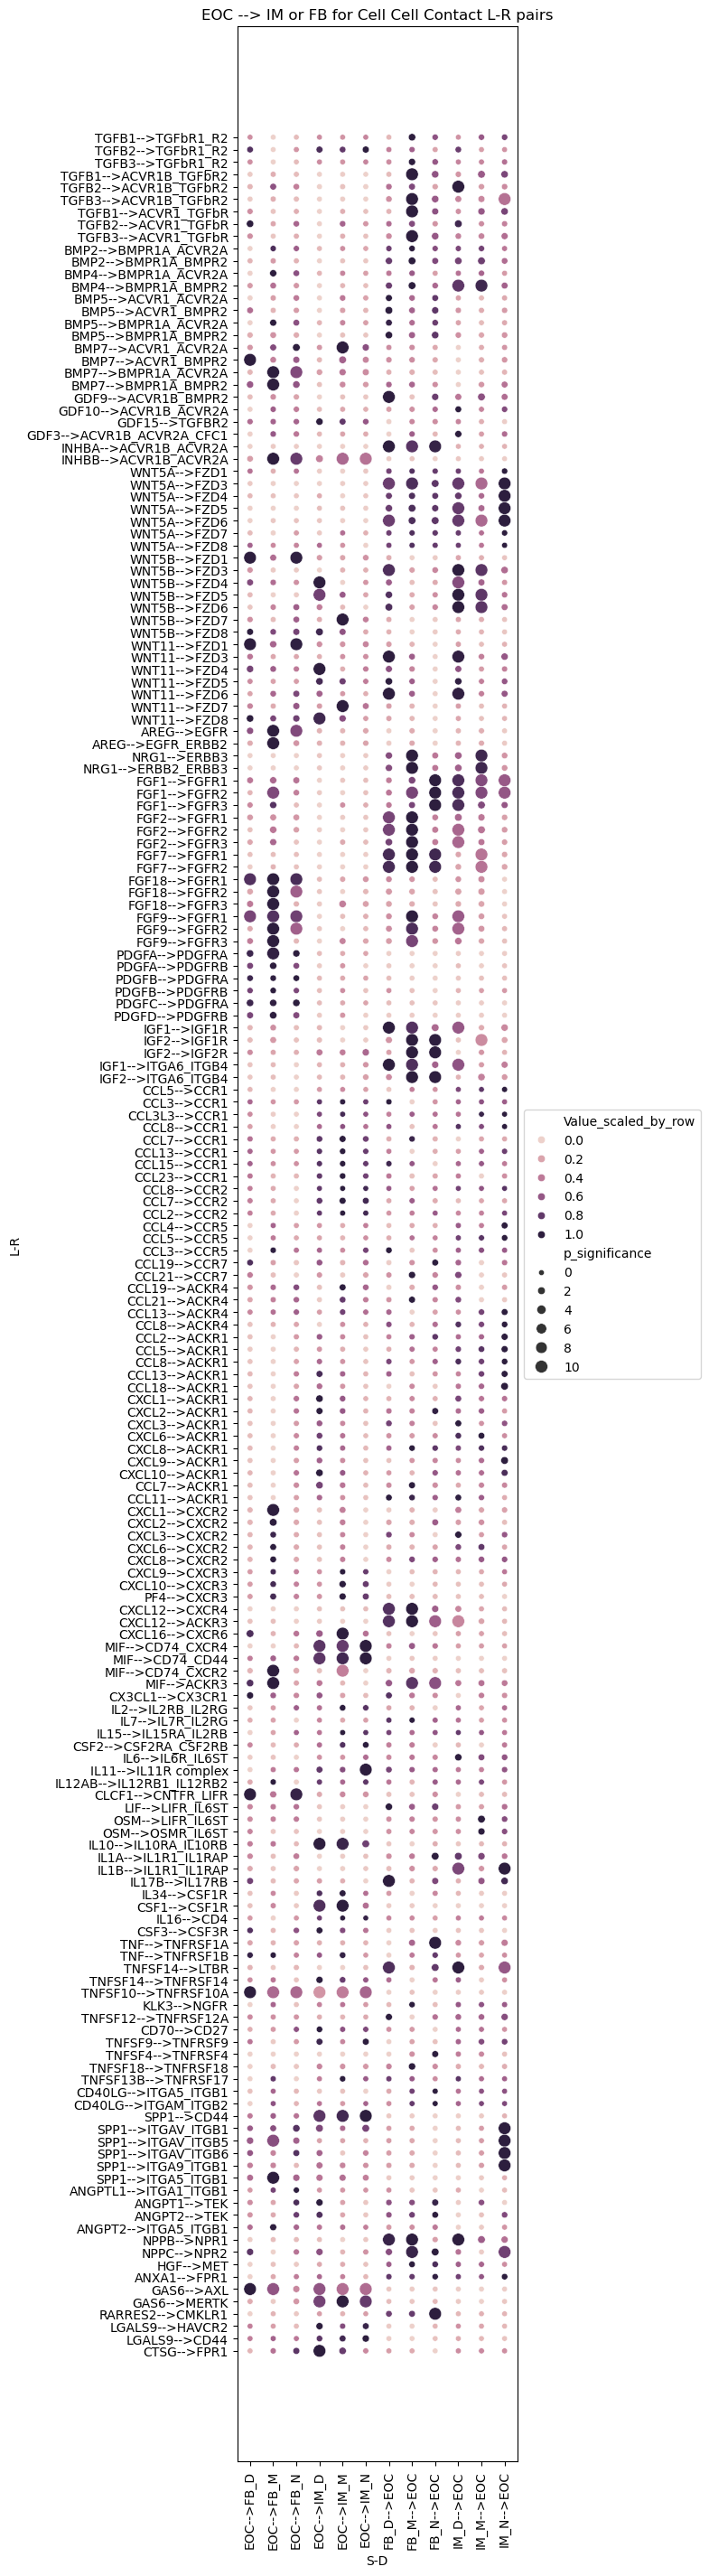

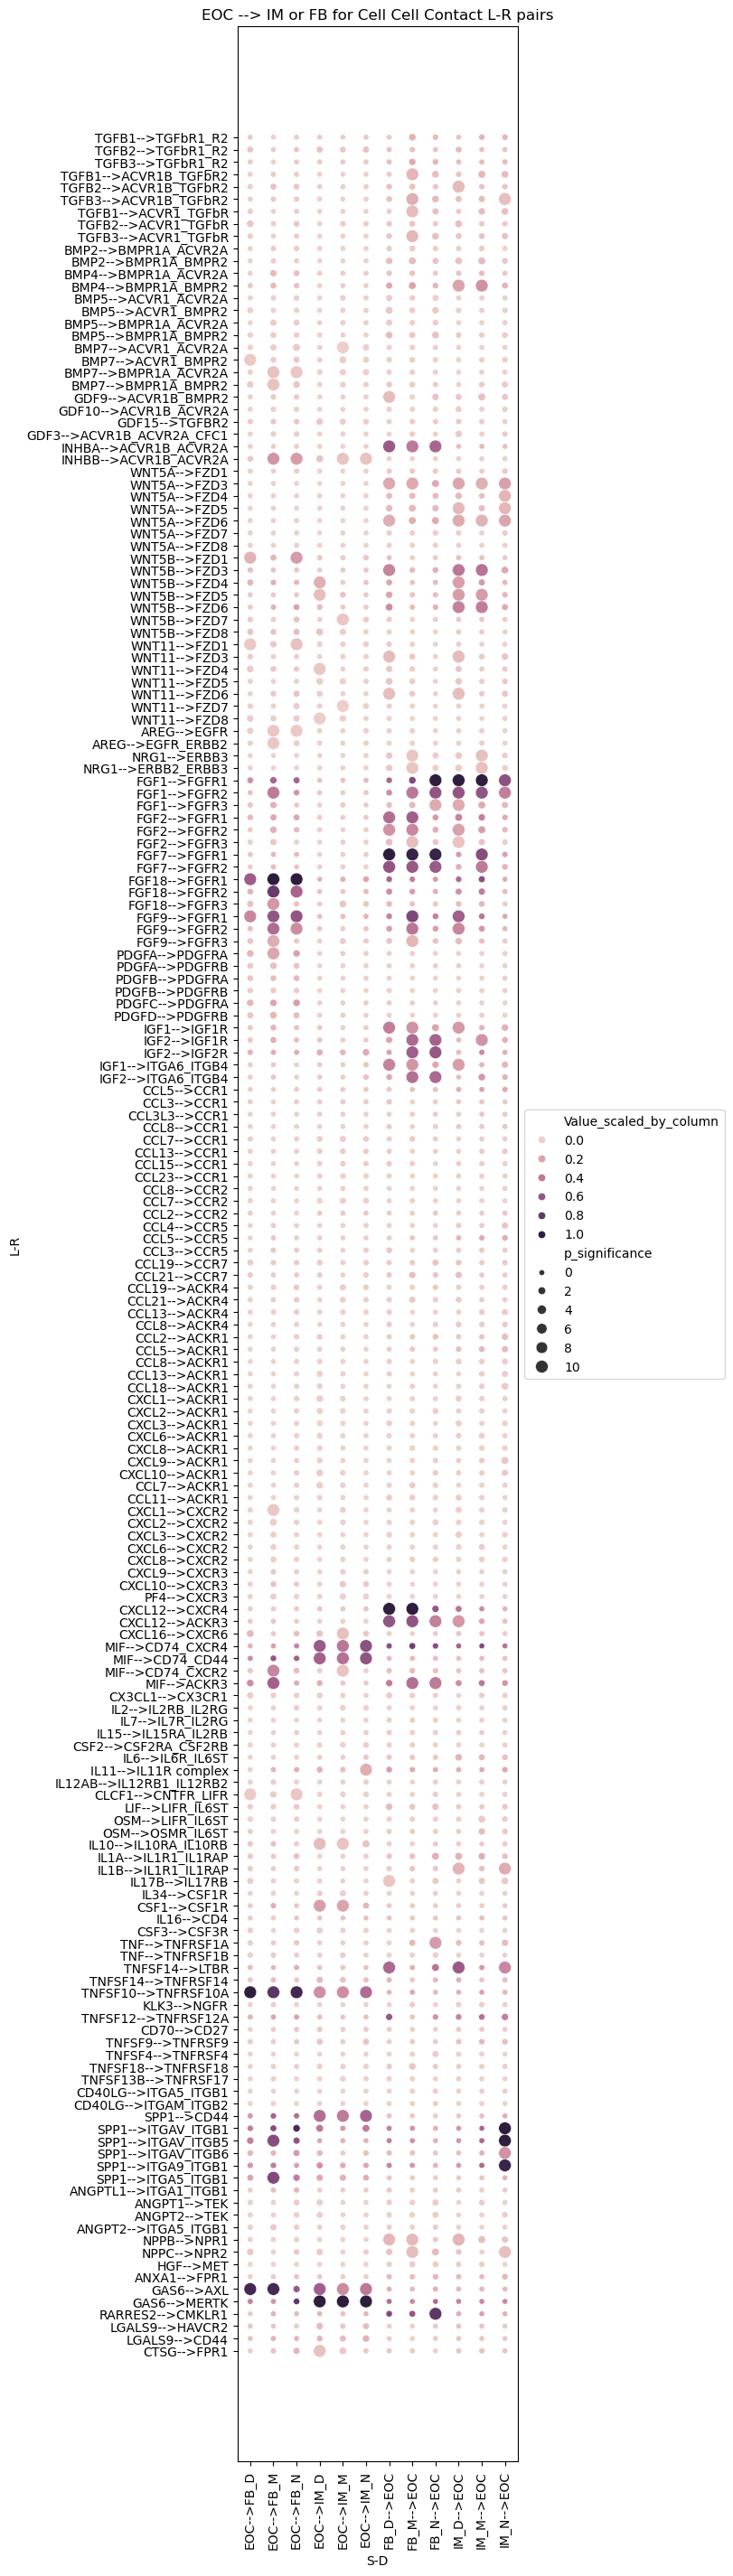

In [176]:
plt.figure(figsize=(4,35))
sns.scatterplot(data=tmp,
                x='S-D',
                y='L-R',
                hue='Value_scaled_by_row',
                size='p_significance',
                sizes=(20,100))
plt.xticks(rotation='vertical')
plt.title('EOC --> IM or FB for Cell Cell Contact L-R pairs')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), title='')
plt.show()

plt.figure(figsize=(4,35))
sns.scatterplot(data=tmp,
                x='S-D',
                y='L-R',
                hue='Value_scaled_by_column',
                size='p_significance',
                sizes=(20,100))
plt.xticks(rotation='vertical')
plt.title('EOC --> IM or FB for Cell Cell Contact L-R pairs')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), title='')
plt.show()

tmp.to_csv(data_save+'SS_CCI_EOC_FB_IM.csv')

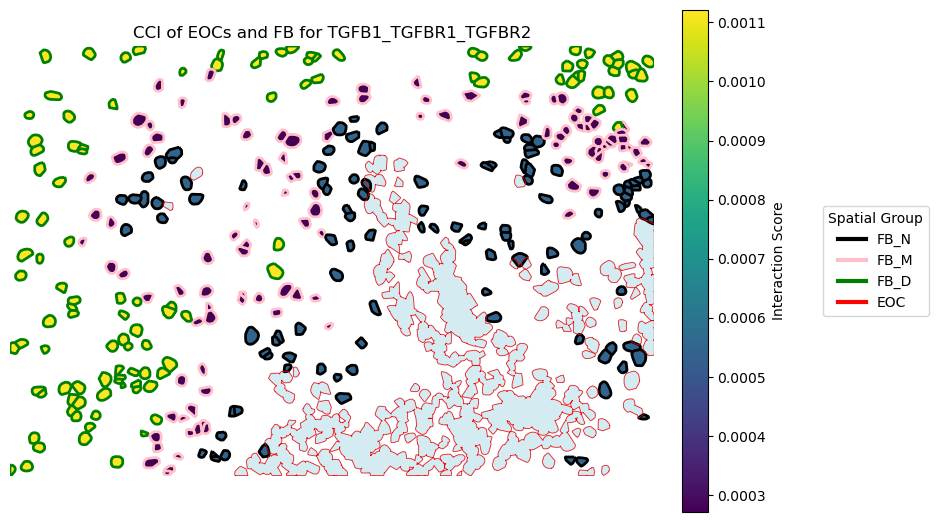

In [196]:
# visualization in polygon plot (Secreted Signaling as an example)
## from EOC to FB (the same applied for IM)
pathway = 'TGFB1_TGFBR1_TGFBR2'

df_v = gdf_FB.merge(df_CC_SS, left_on='spatial_group', right_on='target')
df_v = df_v[df_v['source'] == 'EOC']
df_v = df_v[df_v['interaction_name_2'] == pathway]


fig, ax = plt.subplots(figsize=(9,9))

if merged_polygon.geom_type == 'Polygon':
    ax.fill(*merged.exterior.xy, color='lightblue', alpha=0.5)
    ax.plot(*boundary.xy, color='red', linewidth=0.5)
elif merged_polygon.geom_type == 'MultiPolygon':
    for poly in merged_polygon.geoms:
        ax.fill(*poly.exterior.xy, color='lightblue', alpha=0.5)
        ax.plot(*poly.exterior.xy, color='red', linewidth=0.5)


cmap = cm.viridis  # You can choose other colormaps like 'plasma', 'inferno', etc.
norm = colors.Normalize(vmin=df_v['score'].min(), vmax=df_v['score'].max())

# Map normalized values to colors
df_v['fill_color'] = df_v['score'].apply(lambda x: colors.to_hex(cmap(norm(x))))

edge_color_map = {
    'FB_N': 'black',
    'FB_M': 'pink',
    'FB_D': 'green',
    'EOC':'red'
}
df_v['edge_color'] = df_v['spatial_group'].map(edge_color_map)

df_v.plot(ax=ax,
            facecolor=df_v['fill_color'],
            edgecolor=df_v['edge_color'],
            linewidth=2)


sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, orientation='vertical', fraction=0.036, pad=0.04)
cbar.set_label('Interaction Score')

legend_elements = [Line2D([0], [0], color=color, lw=3, label=group)
                   for group, color in edge_color_map.items()]
ax.legend(handles=legend_elements, title='Spatial Group', loc='center left', bbox_to_anchor=(1.25, 0.5))


ax.set_aspect('equal')
ax.set_xlim(0, xlim_image)
ax.set_ylim(0, ylim_image)
ax.axis('off')
plt.title("CCI of EOCs and FB for "+pathway)
plt.show()


In [218]:
# identification of interactions monotonically changing with spatial group from N to D (take secreted signaling as an example)
df_TS = gdf_FB.merge(df_CC_SS, left_on='spatial_group', right_on='target')
df_TS = df_TS[df_TS['source'] == 'EOC']
df_TS['L-R'] = [i+'-->'+j for i,j in zip(df_TS['ligand'].tolist(), df_TS['receptor'].tolist())]
df_TS = df_TS[['target','L-R','score']]
df_TS['target'] = df_TS['target'].map({'FB_N': 0, 'FB_M': 1, 'FB_D': 2})

In [227]:
def fit_trend(group, time='target', expression='score'):
    slope, intercept, r_value, p_value, std_err = linregress(group[time], group[expression])
    return pd.Series({
        'slope': slope,
        'intercept': intercept,
        'r_squared': r_value**2,
        'p_value': p_value
    })

df_trends = df_TS.groupby('L-R').apply(fit_trend).reset_index()
df_trends = df_trends.sort_values(by='r_squared', ascending=False)

In [ ]:
df_TS['target'] = df_TS['target'].map({0: 'FB_N', 1: 'FB_M', 2: 'FB_D'})
df_TS['target'] = pd.Categorical(df_TS['target'], categories=['FB_N', 'FB_M', 'FB_D'], ordered=True)

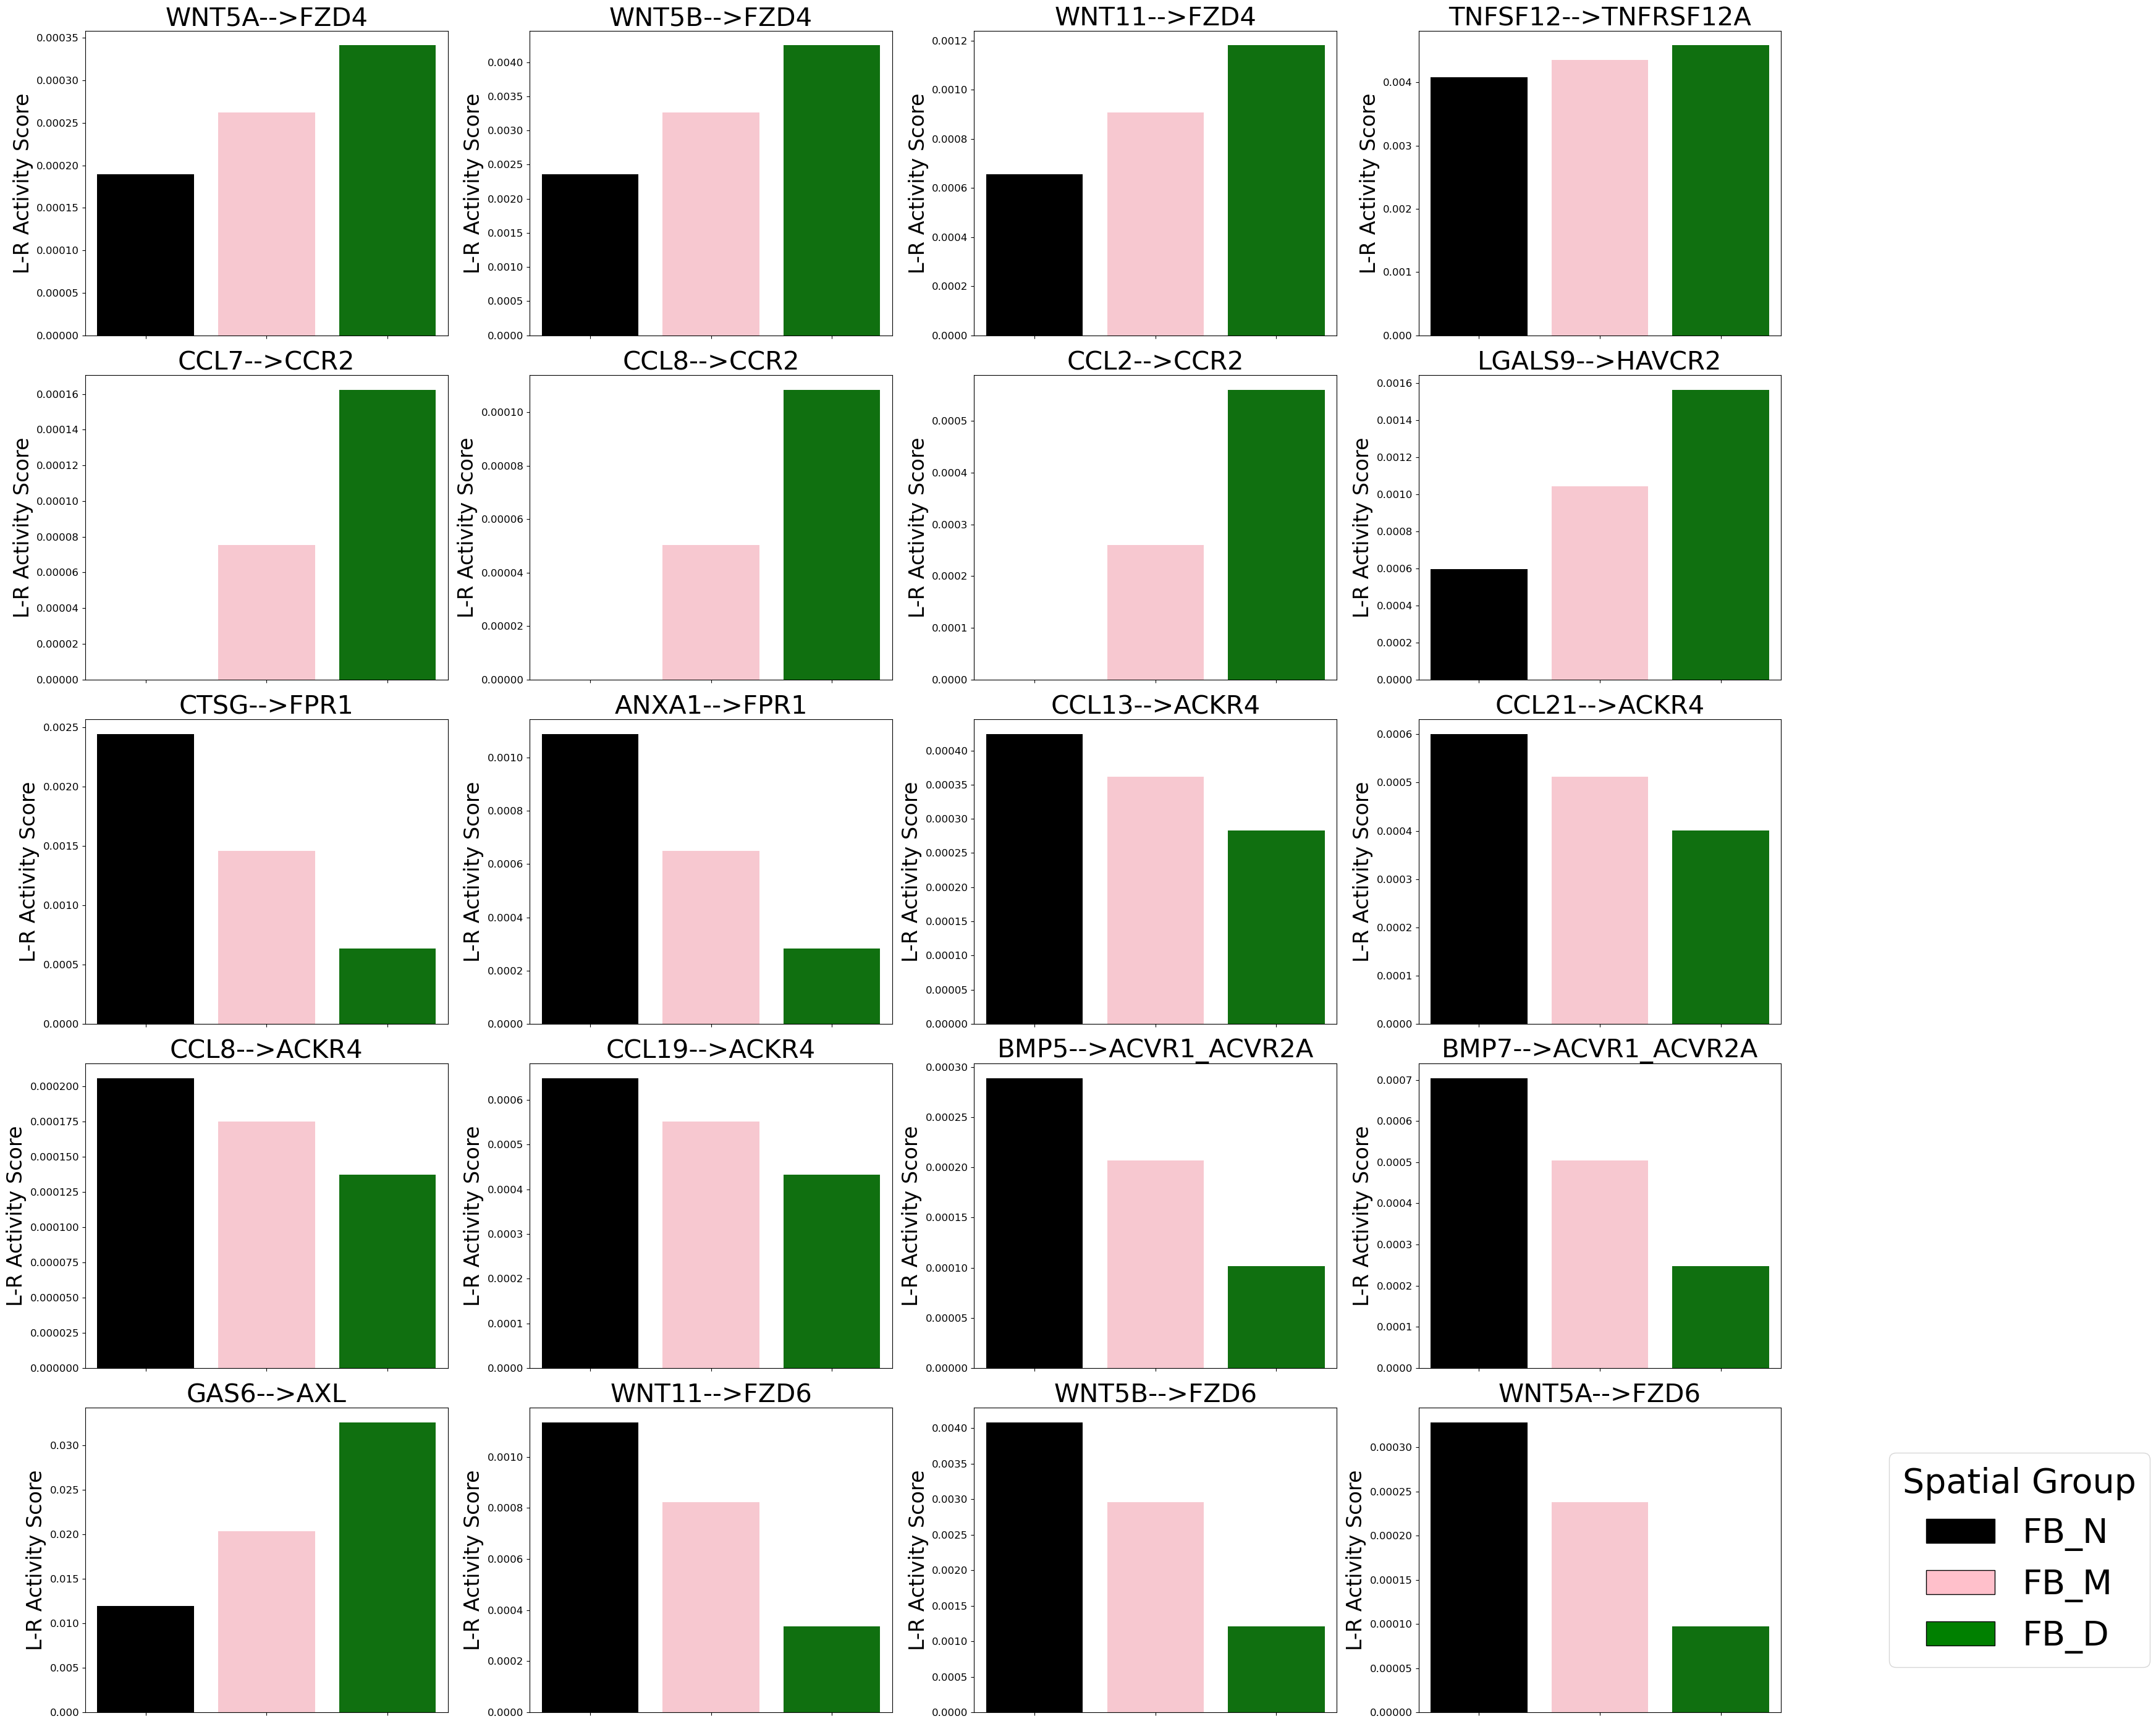

In [272]:
fig, axs = plt.subplots(5,4,figsize=(35,28))
axs = axs.flatten()


fill_color_map = {
    'FB_N': 'black',
    'FB_M': 'pink',
    'FB_D': 'green'
}

for i,lr in enumerate(df_trends['L-R'].tolist()[:20]):
    ax = axs[i]
    sns.barplot(data=df_TS[df_TS['L-R'] == lr], x='target', y='score',hue='target',  ax=ax, legend=False, palette=fill_color_map)
    
    ax.set_title(lr, fontsize=30)
    ax.set_xlabel('', fontsize=24)
    ax.set_ylabel("L-R Activity Score", fontsize=24)
    ax.tick_params(axis='both', labelsize=12)
    ax.set_xticklabels([])




legend_patches = [
    Patch(facecolor=color, edgecolor='black', label=group)
    for group, color in fill_color_map.items()
]


plt.legend(handles=legend_patches, title='Spatial Group', loc='center left', bbox_to_anchor=(1.25, 0.5), fontsize=40, title_fontsize=40)

plt.tight_layout()
plt.show()
